In [52]:
import numpy as np
import os
# os.chdir('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/')
import argparse
import pyfisher
import utils as autils
from utils import DUST_TYPES
from orphics import cosmology
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

In [53]:
dict_plot = {}
dict_plot['GAL040'] = {'linestyle': 'dotted', 'label': 'ACT 40\%'}
dict_plot['GAL060'] = {'linestyle': 'dashed', 'label': 'ACT 60\%'}
dict_plot['GAL070'] = {'linestyle': 'solid', 'label': 'ACT 70\%'}
dict_plot['GAL080'] = {'linestyle': 'dotted', 'label': 'ACT 80\%'}

dict_plot['lmin100'] = {'linestyle': 'dotted', 'label': r'$\ell_{\textrm{min}} = 100$'}
dict_plot['lmin1000'] = {'linestyle': 'dashed', 'label': r'$\ell_{\textrm{min}} = 1000$'}
dict_plot['lmin600'] = {'linestyle': 'solid', 'label': r'$\ell_{\textrm{min}} = 600$'}
dict_plot['lmax3000'] = {'linestyle': 'solid', 'label': r'$\ell_{\textrm{max}} = 3000$'}
dict_plot['lmax3500'] = {'linestyle': 'dashed', 'label': r'$\ell_{\textrm{max}} = 3500$'}

cmap = plt.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 6)]

dict_plot['gauss'] = {'color': colors[0], 'label': 'Gaussian field'}
dict_plot['d9'] = {'color': colors[1], 'label': 'PySM d9'}
dict_plot['d10'] = {'color': colors[2], 'label': 'PySM d10'}
dict_plot['d12'] = {'color': colors[3], 'label': 'PySM d12'}
dict_plot['DF'] = {'color': colors[4], 'label': 'DUSTFILAMENTS'}
dict_plot['van'] = {'color': colors[5], 'label': 'Vansyngel+17'}

In [54]:
args = argparse.Namespace()

args.output_dir = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/local_dustbias/'
# args.dust_freq = 90
args.skyfrac='GAL060'
args.mlmax=4000
# args.mask_subproduct='lensing_masks'
# args.mask_type='dr6v4_20240919'
# args.apodfact='_d2_apo3deg'
# args.daynight='night'
# args.config_name='act_dr6v4'
args.width_ra=15
args.width_dec=10

args.filter_whiteamplitude=12.
args.filter_whitefwhm=1.4
args.nsims_mf=50

# mask_options = {'apodfact': args.apodfact, 'daynight': args.daynight}
# dm = DataModel.from_config(args.config_name)

In [4]:
def args_baseline(args, skyfrac, dust_type):
    
    args.lmax=3000
    args.lmin=600
    args.dust_type=dust_type
    args.dust_freq=90.
    args.skyfrac=skyfrac
    
    return args

In [5]:
npatches = {}
submap_coord = {}
for skyfrac in autils.FSKYS:
    submap_coord[skyfrac] = np.load(args.output_dir + f'local_masks/submap_coordinates_{args.skyfrac}_{args.width_ra}_{args.width_dec}.npy')
    npatches[skyfrac] = submap_coord[skyfrac].shape[0]

In [6]:
path_recons = lambda ipatch, args, tag, mf: args.output_dir + f'stage_reconstruction/{autils.get_recons_name(ipatch, args, tag, mf)}'

In [7]:
raw_4pt = {}
rawmf_4pt = {}
n0_4pt = {}
reconstructed_cl = {}
cl_nobias = {}

#for skyfrac in autils.FSKYS:
skyfrac='GAL060'
for dust_type in autils.DUST_TYPES:
    for test in ['baseline', 'lmin', 'lmax']:
        
        raw_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
        rawmf_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
        n0_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
        cl_nobias[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]

In [8]:
okreconstructed_cl = {}
okcl_nobias = {}

#for skyfrac in autils.FSKYS:
skyfrac='GAL060'
for dust_type in autils.DUST_TYPES:
    for test in ['baseline', 'lmin', 'lmax']:

        okcl_nobias[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]

In [9]:
TEST='baseline'
SKYFRAC='GAL060'
# for SKYFRAC in autils.FSKYS:
#     print(SKYFRAC)
for n in range(npatches[SKYFRAC]):
    #print(n)
    for dust_type in autils.DUST_TYPES:
        raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=False))
        rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=True))
        n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'N0', mf=False))

# for SKYFRAC in autils.FSKYS:
#     print(SKYFRAC)
for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'd9_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]
        okcl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

# for SKYFRAC in autils.FSKYS:
#     print(SKYFRAC)
for dust_type in autils.DUST_TYPES:
    reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)
    okreconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(okcl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

/tmp/ipykernel_1068685/687841813.py:22: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)
/tmp/ipykernel_1068685/687841813.py:23: RuntimeWarning: Mean of empty slice
  okreconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(okcl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


In [10]:
ell_arr = np.arange(args.mlmax+1)
lfac = (ell_arr * (ell_arr + 1))**2 / (2 * np.pi)
lfac_2pt = ell_arr * (ell_arr + 1)
lcut = 50
nbands_log = 20
nbands_lin = 5
lbands = np.concatenate((np.linspace(2, lcut, nbands_lin, dtype=int)[:-1], np.logspace(np.log10(lcut), np.log10(args.mlmax), nbands_log+1, dtype=int)))#  dtype=int)
nbands = len(lbands)-1
# leff = (lbands[1:] + lbands[:-1])/2. # [np.mean(np.arange(x,y)) for x,y in zip(lbands[:-1], lbands[1:])]

In [11]:
theory = cosmology.default_theory()
tclkk = theory.gCl('kk',ell_arr)

tclpp = tclkk * 4 / (ell_arr * (ell_arr+1))**2

/tmp/ipykernel_1068685/2357927111.py:4: RuntimeWarning: invalid value encountered in divide
  tclpp = tclkk * 4 / (ell_arr * (ell_arr+1))**2


In [12]:
cents, bins = pyfisher.get_binner(lbands,interpolate=False)

Text(0, 0.5, '$L^2(L+1)^2C_L^{\\phi\\phi}/2\\pi$')

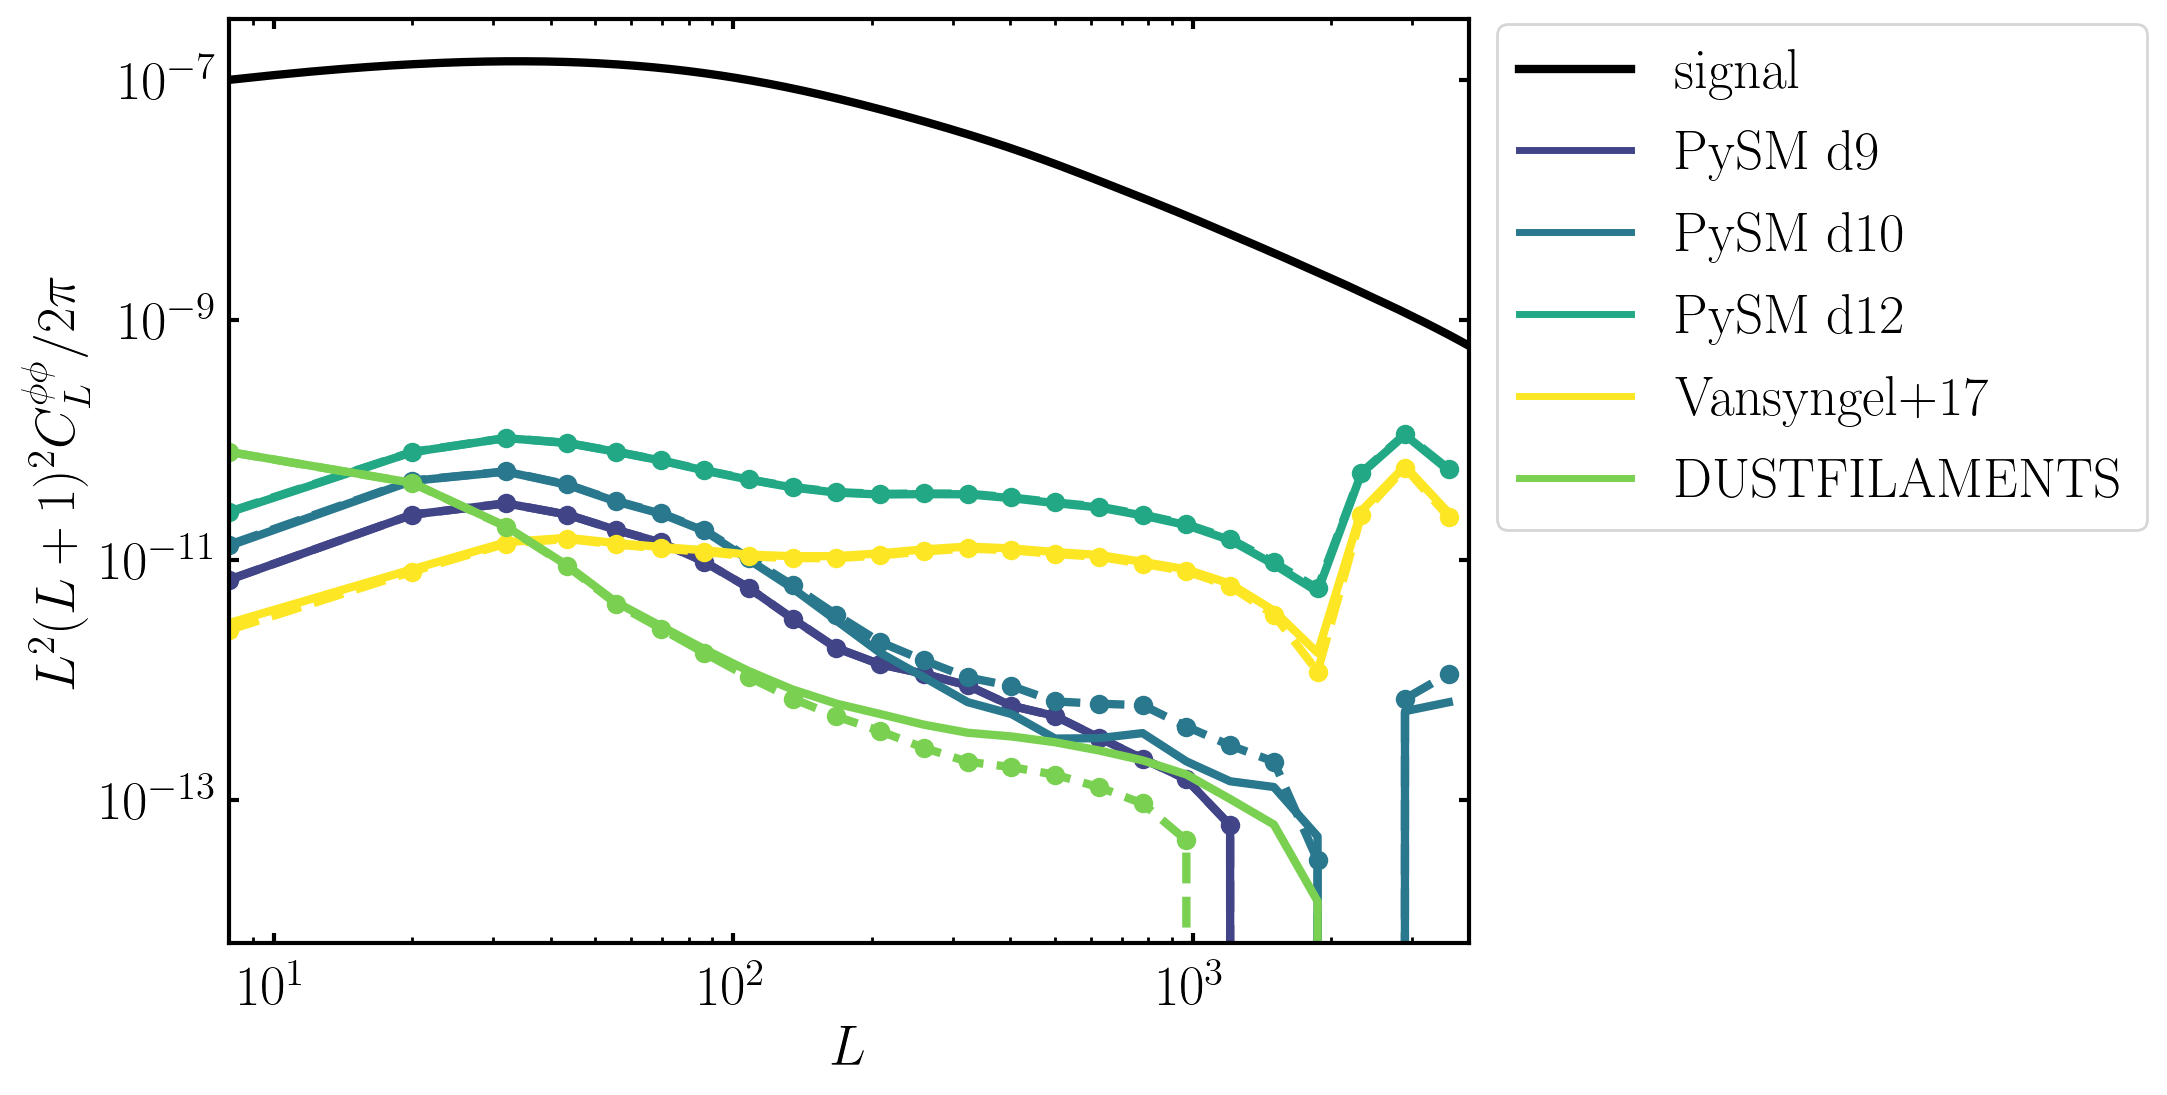

In [56]:
TEST='baseline'
SKYFRAC = 'GAL060'

fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=200)

ax.loglog(ell_arr[2:], (tclpp*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')
for dust_type in autils.DUST_TYPES[1:]:
    #for SKYFRAC in autils.FSKYS:
    ax.loglog(cents, (bins(pyfisher.interp(ell_arr, lfac*(reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}']), bounds_error=True))),'o-',color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)#)))#[:args.mlmax+1]*lfac)[2:] / (clpp[:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)
    ax.loglog(cents, (bins(pyfisher.interp(ell_arr, lfac*(okreconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}']), bounds_error=True))),color=dict_plot[dust_type]['color'], linestyle='solid', linewidth = 3, label=dust_type)#)))#[:args.mlmax+1]*lfac)[2:] / (clpp[:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)

#ax.set_yscale('symlog')
#ax.set_ylim(-7e-11, 1e-9)
ax.axhline(0, linestyle='dashed')
# #pyfisher.interp(ell_arr, tclkk, bounds_error=True))
ax.set_xlim(8,4000)

custom_lines1 = [Line2D([0], [0], color='black', linestyle = 'solid', lw=3)]
custom_lines2 = [Line2D([0], [0], color=dict_plot[fg_type]['color'], linestyle = 'solid', lw=2.5) for fg_type in autils.DUST_TYPES[1:]]
#custom_lines3 = [Line2D([0], [0], color='gray', linestyle = dict_plot[GAL]['linestyle'], lw=2.5) for GAL in autils.FSKYS]

custom_lines = custom_lines1 + custom_lines2 #+ custom_lines3

legend_lines1 = ['signal']
legend_lines2 = [dict_plot[fg_type]['label'] for fg_type in autils.DUST_TYPES[1:]]
#legend_lines3 = [dict_plot[GAL]['label'] for GAL in autils.FSKYS]

legend_lines = legend_lines1 + legend_lines2 #+legend_lines3 

legend = ax.legend(custom_lines, legend_lines, bbox_to_anchor=(1, 1.025), loc = 'upper left')

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$')

#fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/baseline_fsky.png', bbox_inches='tight')

In [26]:
ell_arr = np.arange(args.mlmax+1)
lfac =  (ell_arr * (ell_arr + 1))**2 / (2 * np.pi)

In [59]:
def plot_recons(test, ni=10):
    
    for n in range(ni):
        print(n)
        
        fig, ax = plt.subplots(1, 1, figsize=(4,3))
        ax.loglog(ell_arr[2:], (raw_4pt[test][n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
        ax.loglog(ell_arr[2:], (n0_4pt['d9_GAL060_baseline'][n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
        ax.loglog(ell_arr[2:], (rawmf_4pt[test][n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')
        #ax.loglog(ell_arr[2:], (cl_nobias[test][n][:args.mlmax+1]*lfac)[2:], color='gold', linestyle='dashed', linewidth = 3, label='mf sub cl')
        #ax.loglog(ell_arr[2:], (okcl_nobias[test][n][:args.mlmax+1]*lfac)[2:], color='orange', linestyle='dashed', linewidth = 3, label='mf sub cl')
        
        plt.show()

0


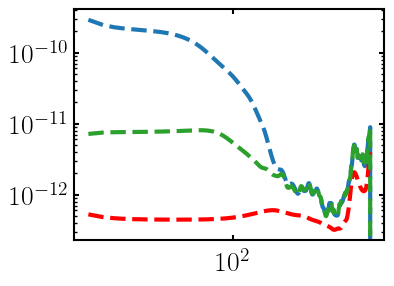

1


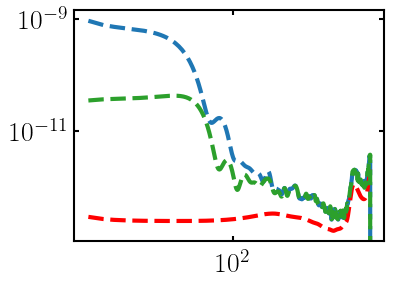

2


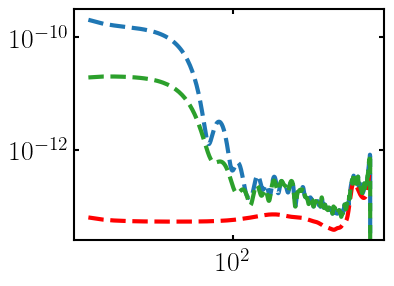

3


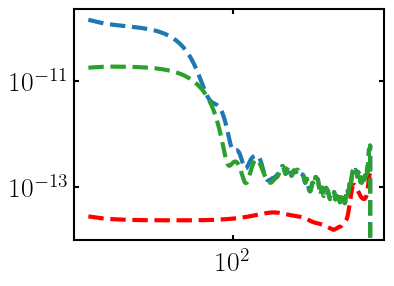

4


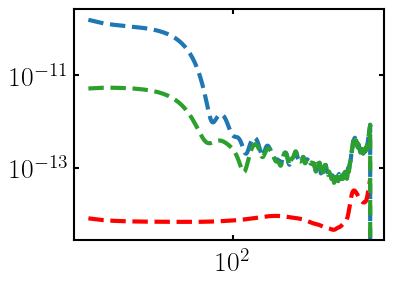

5


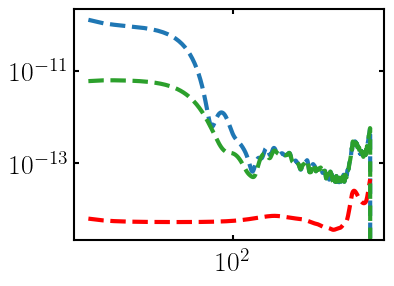

6


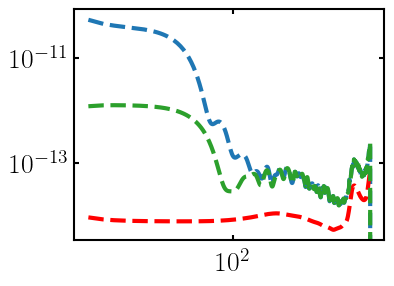

7


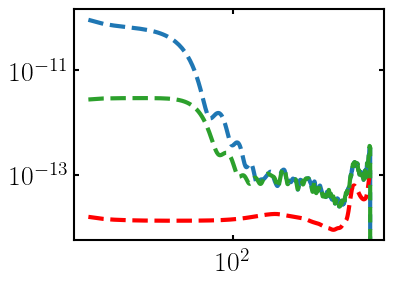

8


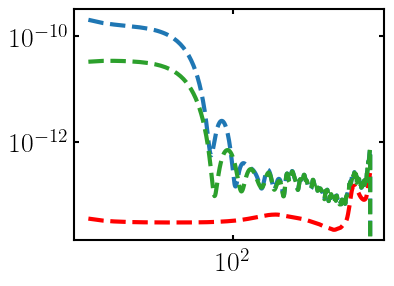

9


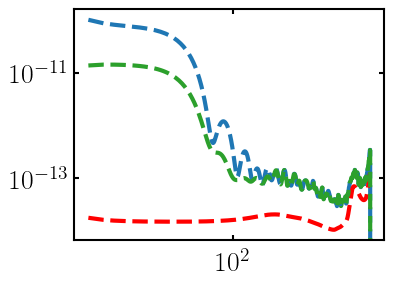

In [60]:
plot_recons('DF_GAL060_baseline')

0


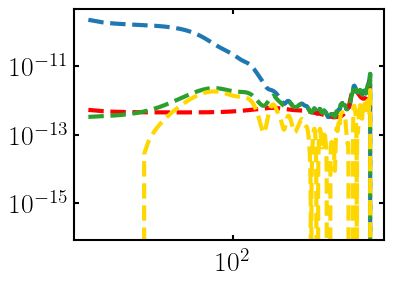

1


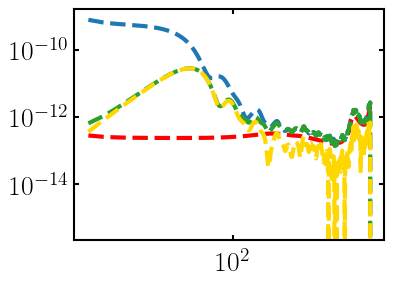

2


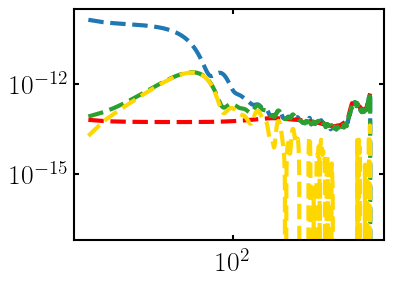

3


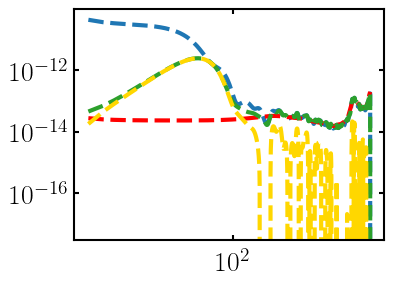

4


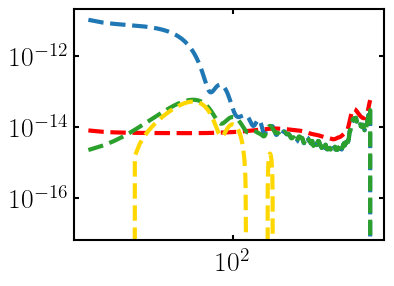

5


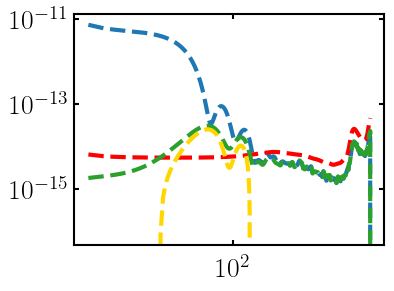

6


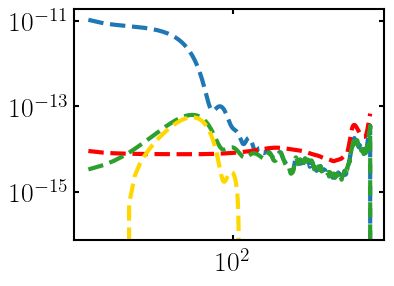

7


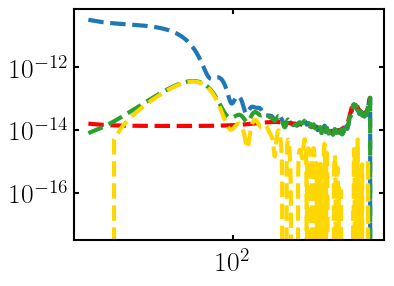

8


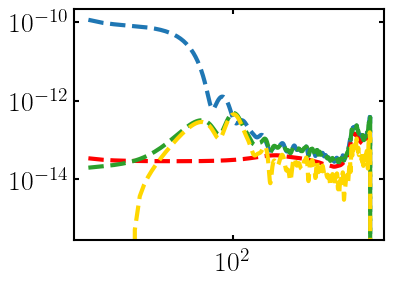

9


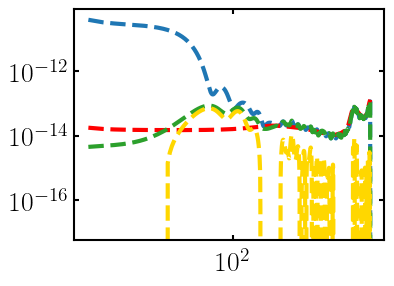

In [34]:
plot_recons('d10_GAL060_baseline')

0


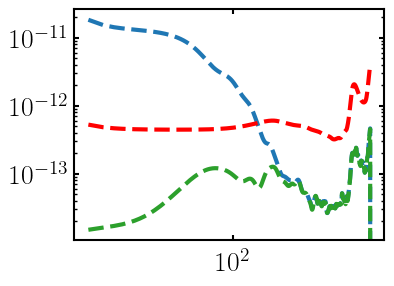

1


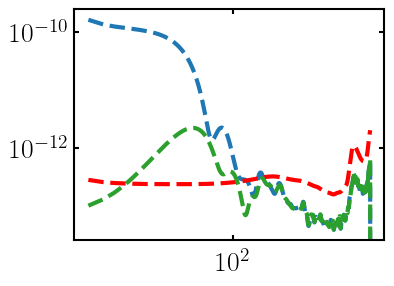

2


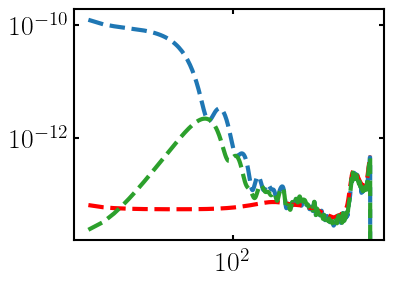

3


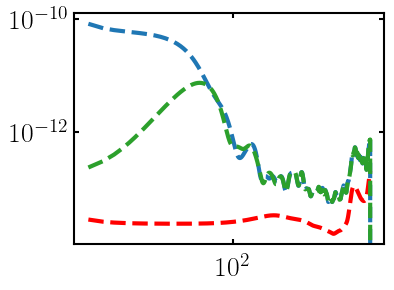

4


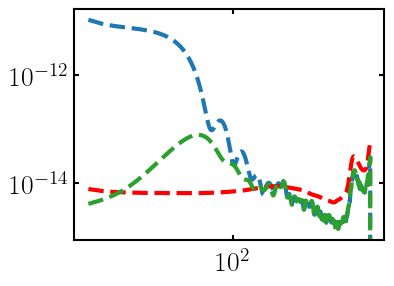

5


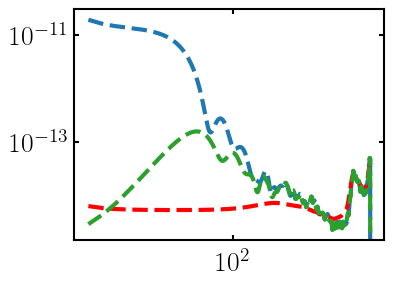

6


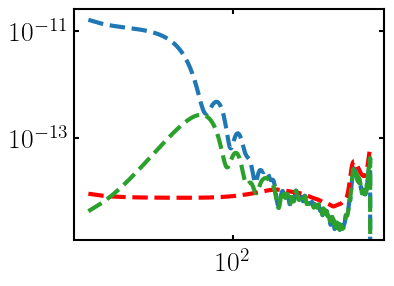

7


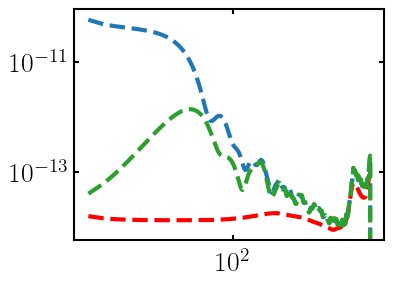

8


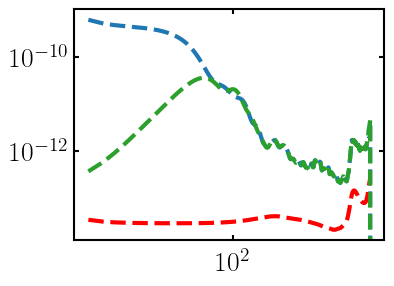

9


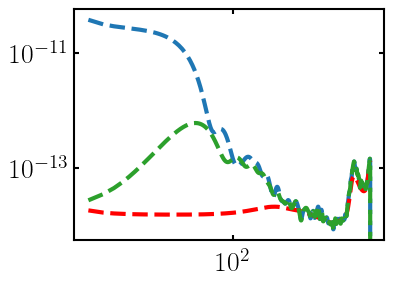

In [28]:
plot_recons('d12_GAL060_baseline')

0


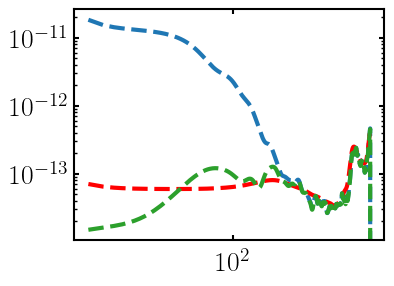

1


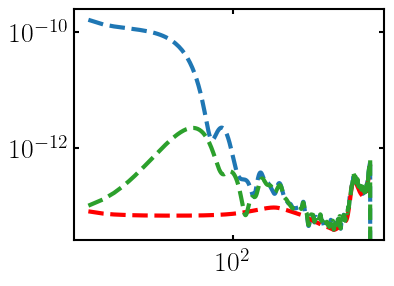

2


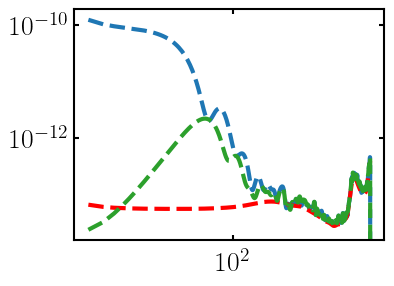

3


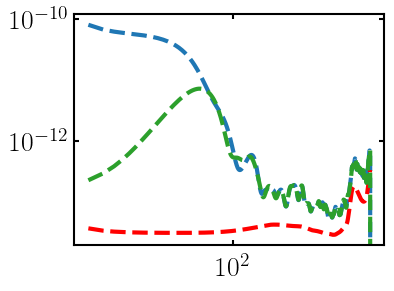

4


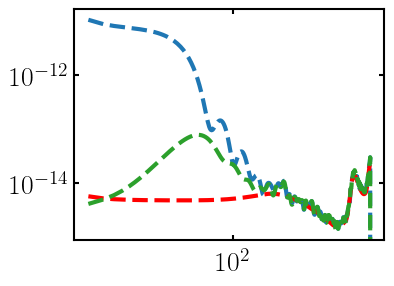

5


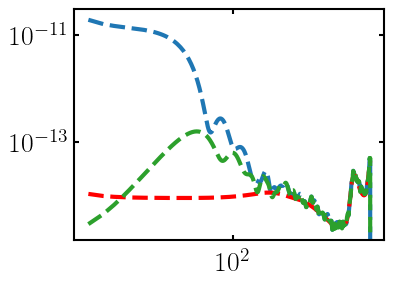

6


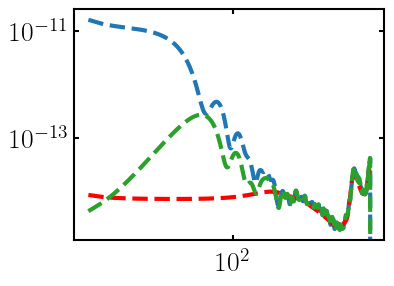

7


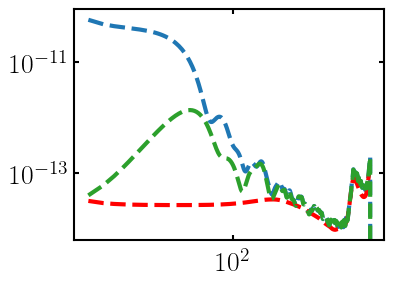

8


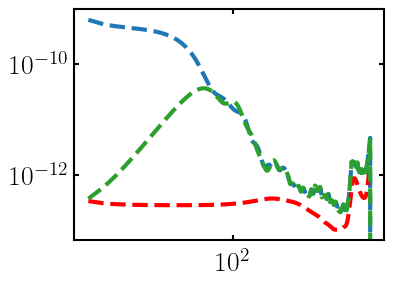

9


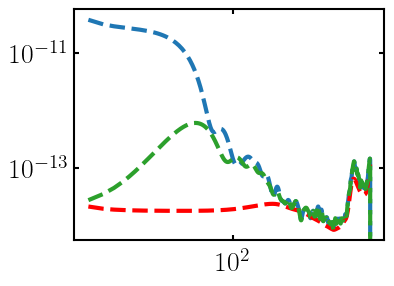

In [16]:
plot_recons('d10_GAL060_baseline')

0


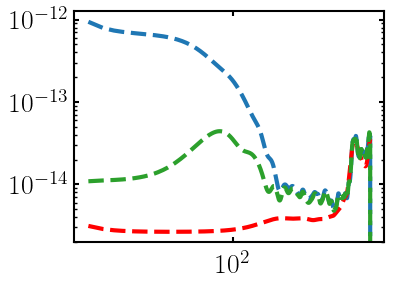

1


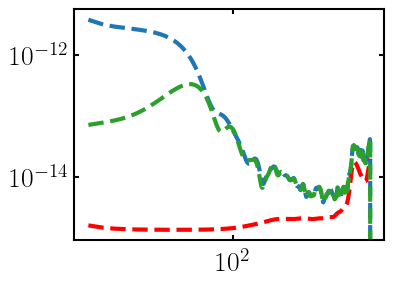

2


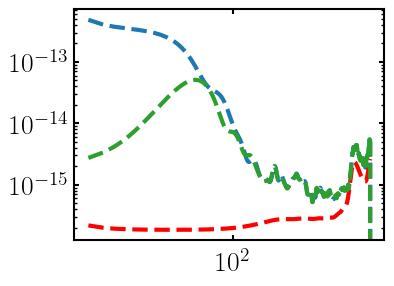

3


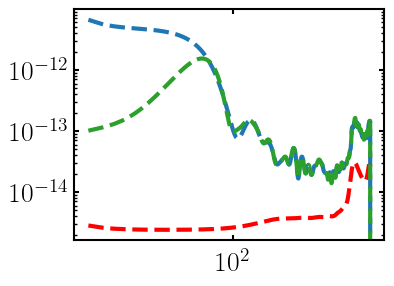

4


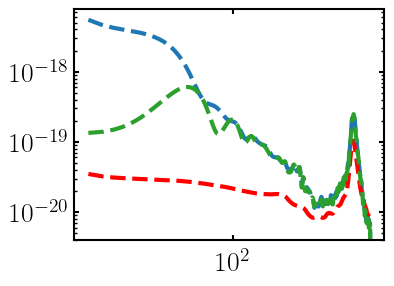

5


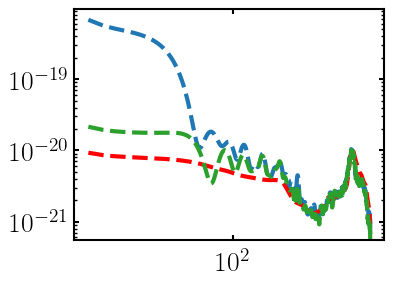

6


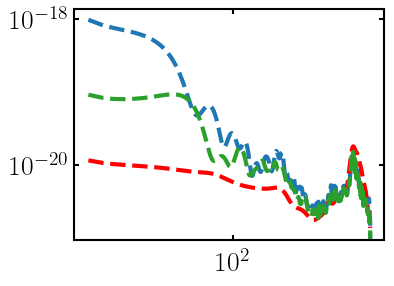

7


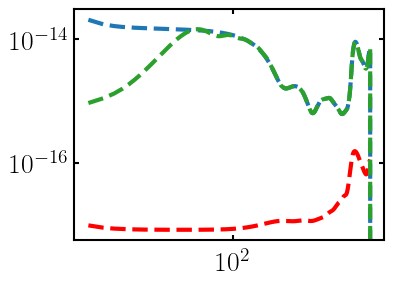

8


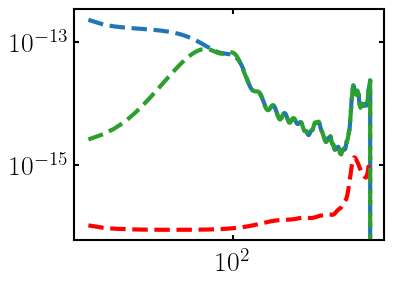

9


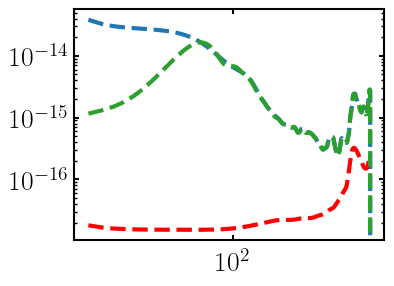

In [17]:
plot_recons('van_GAL060_baseline')

0


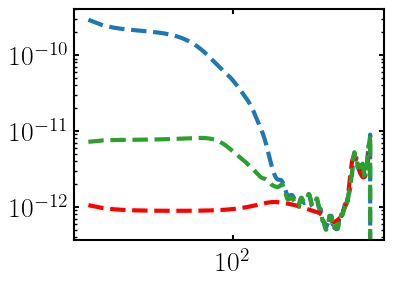

1


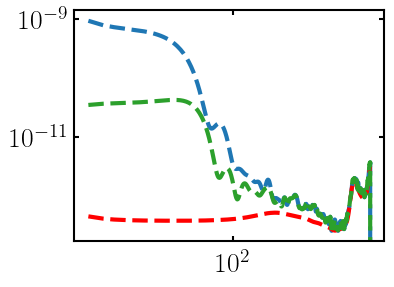

2


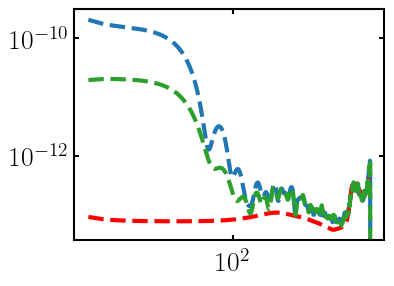

3


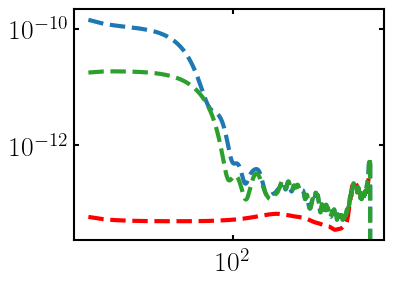

4


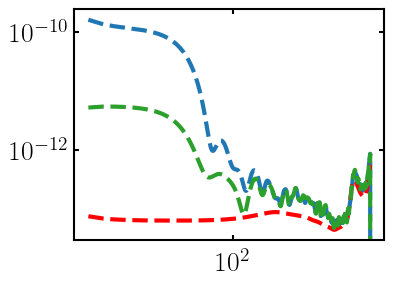

5


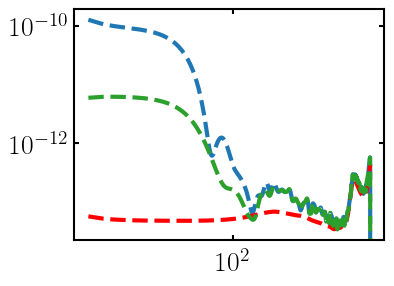

6


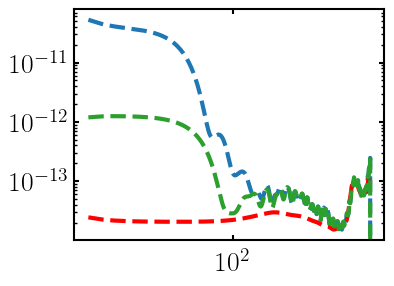

7


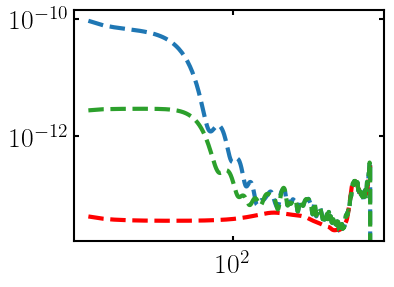

8


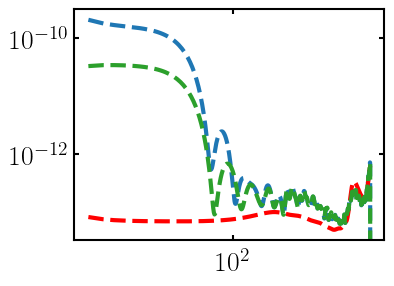

9


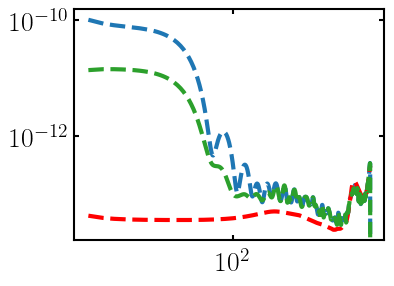

In [18]:
plot_recons('DF_GAL060_baseline')

0


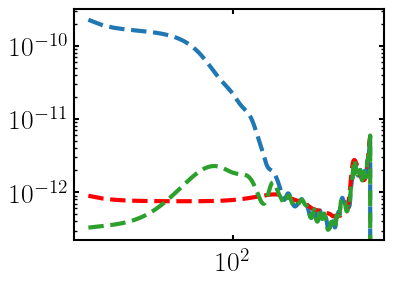

1


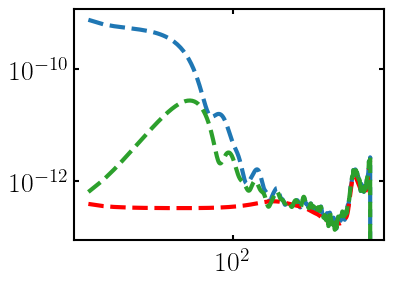

2


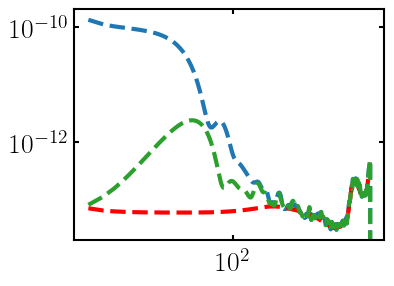

3


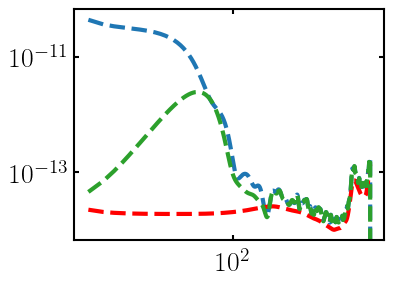

4


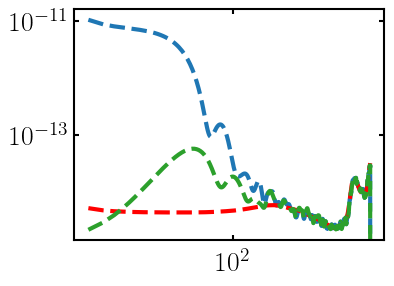

5


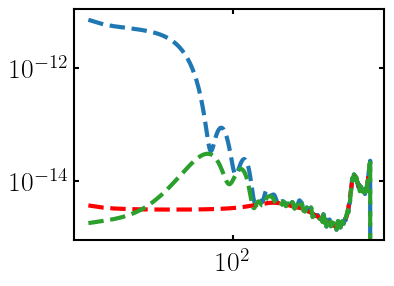

6


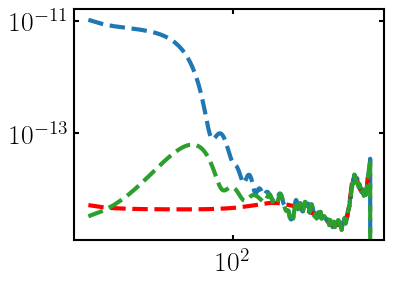

7


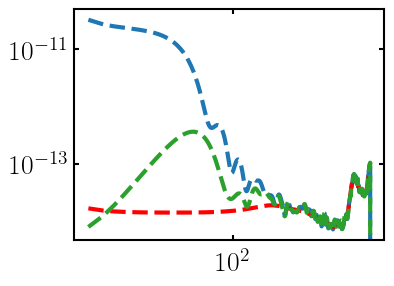

8


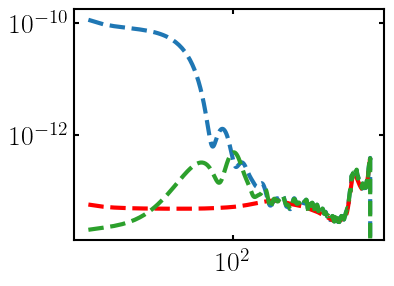

9


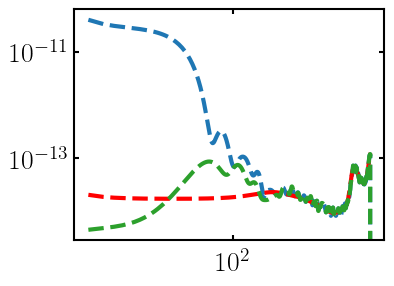

In [19]:
plot_recons('d10_GAL060_baseline')

In [77]:
def plot_recons_grid(test, istart=0, ni=6):
    
    fig, ax = plt.subplots(3,2, sharex=True, sharey=False, figsize=(6,6), dpi=200)
    ax = ax.flatten()
    for i in range(ni):
        n=istart+i
        
        #print(n)
        
        
        ax[i].loglog(ell_arr[2:], (raw_4pt[test][n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
        ax[i].loglog(ell_arr[2:], (n0_4pt[test][n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
        ax[i].loglog(ell_arr[2:], (rawmf_4pt[test][n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')
        # ax[i].set_title(i)
    for i in [-2, -1]:
        ax[i].set_xlabel(r'$L$')
    
    fig.subplots_adjust(wspace=0.4)
    fig.suptitle(test.split('_')[0])
    fig.savefig(f'./Figures/recons_grid_{test}.png', bbox_inches='tight')
    plt.show()

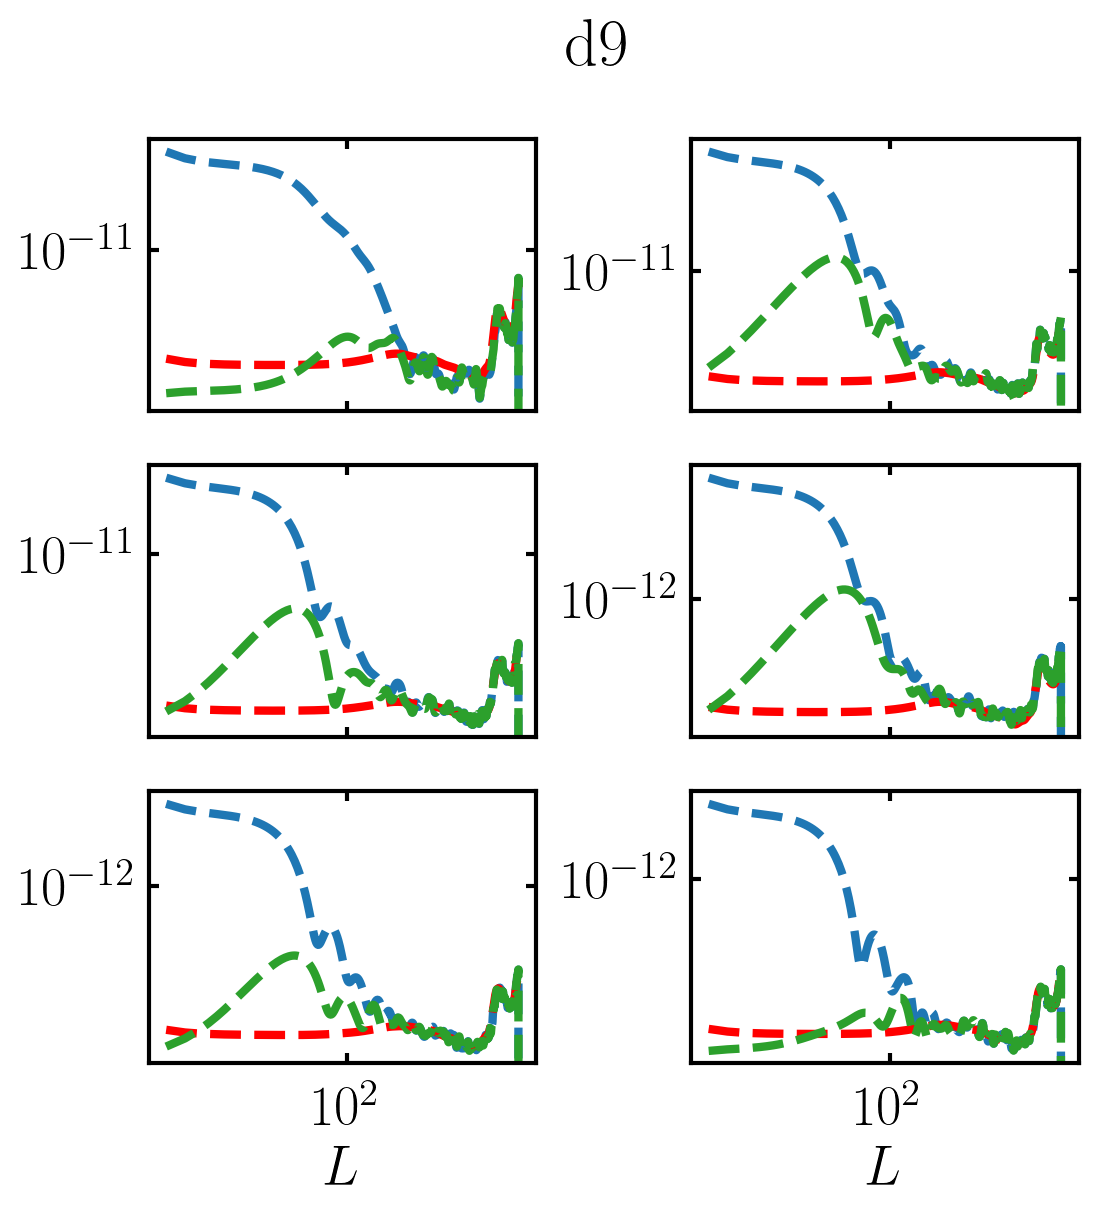

In [78]:
plot_recons_grid('d9_GAL060_baseline')

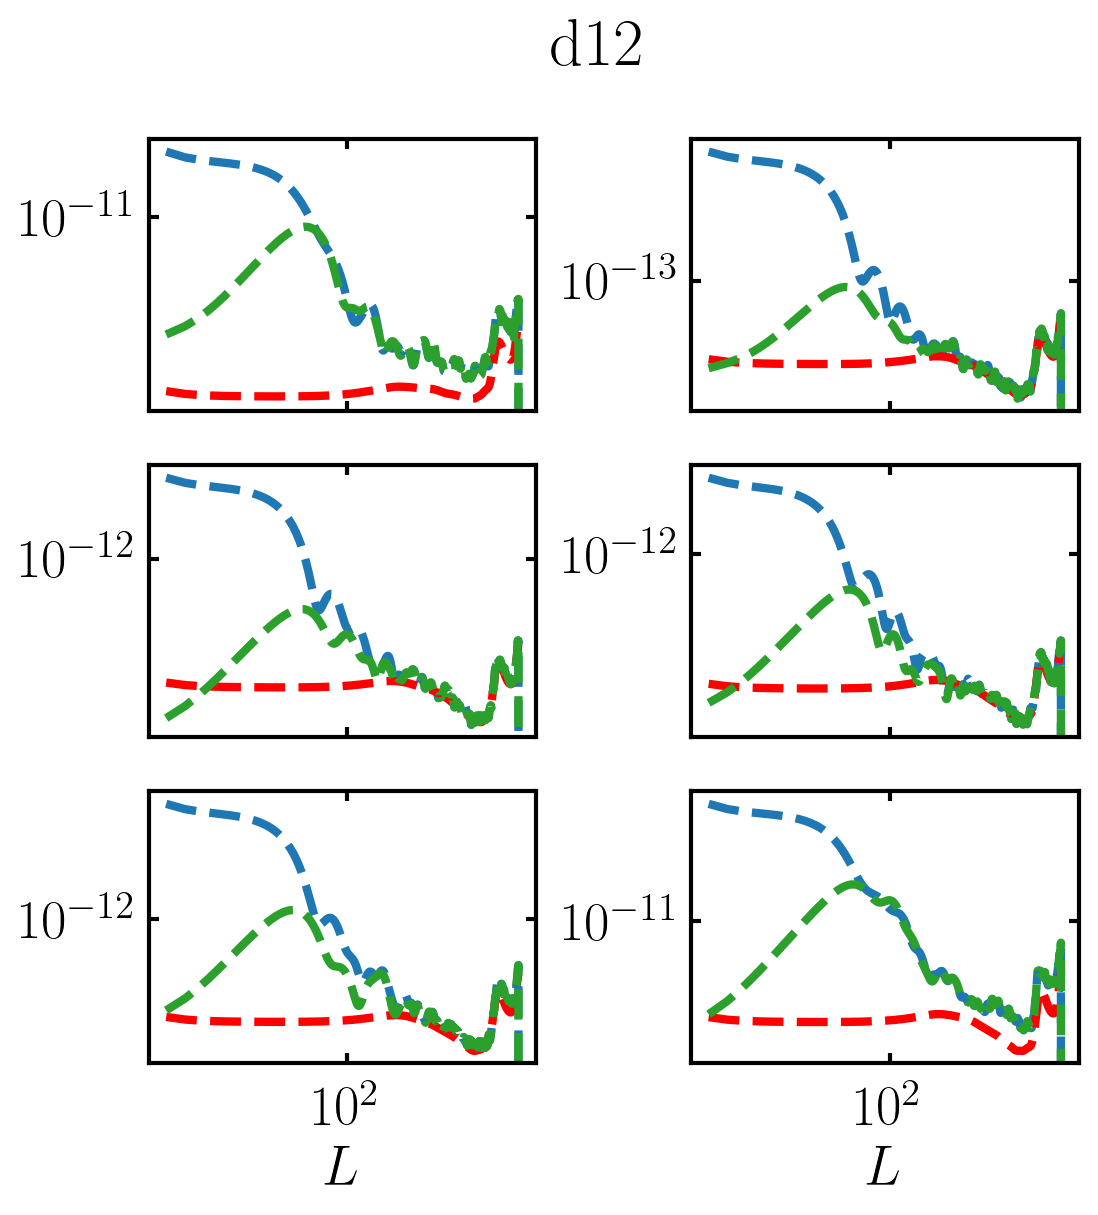

In [79]:
plot_recons_grid('d12_GAL060_baseline', istart=3)